# Player Role Stats
- Which roles are common?
- What's the most common combinaion of roles?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import seaborn as sns
import sys
sys.path.insert(0, '../scripts/')
from football_field import create_football_field
from plots import plot_play

pd.set_option('display.max_columns', 500)

## Data import

In [3]:
pprd = pd.read_csv('../input/play_player_role_data.csv')
pprd['count'] = 1
pprd['play_unique'] = pprd['Season_Year'].astype('str').add((pprd['GameKey']).astype('str')).add((pprd['PlayID']).astype('str'))
vr = pd.read_csv('../input/video_review.csv')
vr['play_unique'] = vr['Season_Year'].astype('str').add((vr['GameKey']).astype('str')).add((vr['PlayID']).astype('str'))

In [4]:
vr.Primary_Partner_GSISID = vr.Primary_Partner_GSISID.fillna(0).replace('Unclear',0).astype('int64')
vr_merged = pd.merge(pd.merge(vr, pprd), pprd, left_on=['play_unique','Primary_Partner_GSISID'],
                                   right_on=['play_unique','GSISID'], how='left').fillna('None')

In [5]:
pprd.groupby(['play_unique', 'Role']).count()['count'].reset_index().sort_values('count').groupby('count').count()

,play_unique,Role
count,,
1,146183,146183
2,192,192
3,2,2


# 192 play/roles duplicated on a single play, 2 plays where 3 roles appear

In [6]:
pprd.groupby(['play_unique', 'Role']).count()['count'].reset_index().sort_values('count').tail(10)

,play_unique,Role,count
100843,20174591605,PR,2
47094,20163004422,PDL2,2
111319,20175071474,PR,2
75814,20173493216,PLW,2
136080,20176213368,PDL4,2
105817,2017481119,PDL2,2
109561,20174992956,PR,2
146197,2017663646,PR,2
34010,2016244136,PDR3,3
130867,2017597728,PR,3


In [7]:
play_roles = pprd.pivot_table(values='count', index='play_unique', columns='Role', aggfunc='mean').fillna(0).reset_index()

# Most/Least Common Roles

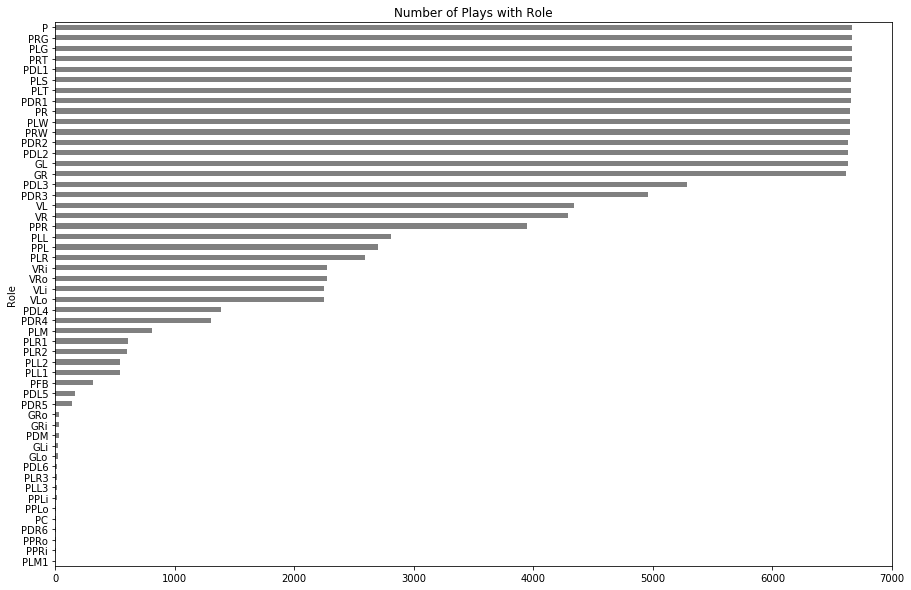

In [8]:
play_roles.drop(columns=['play_unique']) \
    .sum().sort_values() \
    .plot(kind='barh', figsize=(15, 10), title='Number of Plays with Role', color='grey')

In [9]:
role_info = pd.read_csv('../working/role_info.csv', index_col=0)
role_count_df = pd.DataFrame(play_roles.drop(columns=['play_unique']) \
                             .sum() \
                             .sort_values()) \
                            .reset_index() \
                            .rename(columns={0: 'Role Count', 'Role' : 'role'})
role_count_df = pd.merge(role_count_df, role_info)

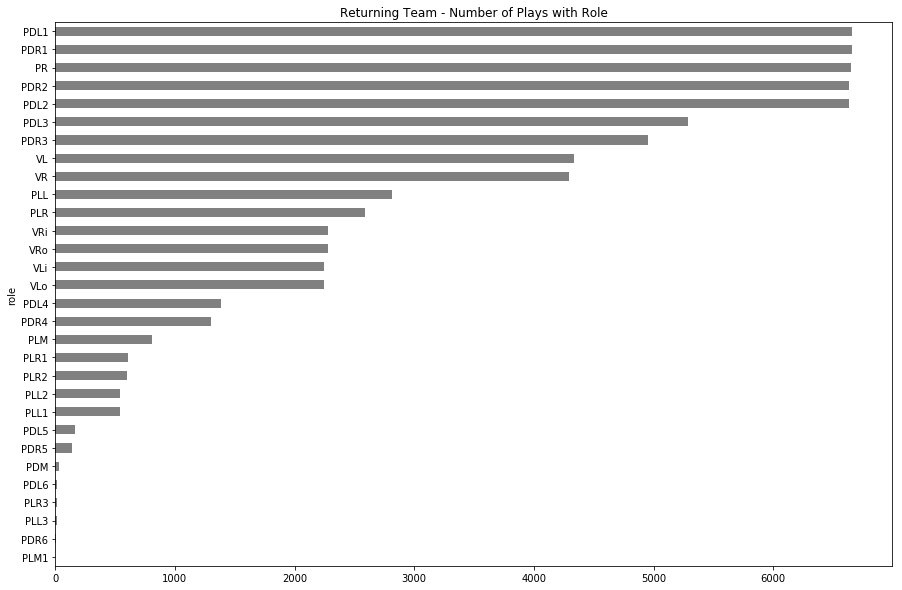

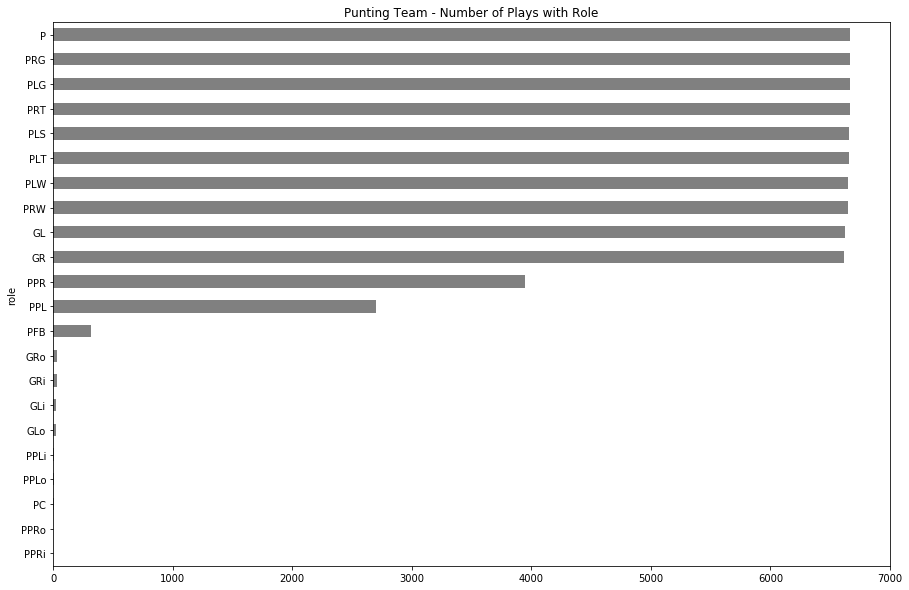

In [10]:
role_count_df.loc[role_count_df['punting_returning_team'] == 'Returning_Team'] \
    .set_index('role')['Role Count'] \
    .plot(kind='barh', figsize=(15, 10), title='Returning Team - Number of Plays with Role', color='grey')
plt.show()
role_count_df.loc[role_count_df['punting_returning_team'] == 'Punting_Team'] \
    .set_index('role')['Role Count'] \
    .plot(kind='barh', figsize=(15, 10), title='Punting Team - Number of Plays with Role', color='grey')
plt.show()

# Cluster to find types of formations

In [11]:
play_roles = pprd.pivot_table(values='count', index='play_unique', columns='Role', aggfunc='mean').fillna(0).reset_index()
km = KMeans(n_clusters=10, random_state=5)
km.fit(play_roles.set_index('play_unique'))
clusters = km.predict(play_roles.set_index('play_unique'))
play_roles['cluster'] = clusters

In [12]:
play_roles.groupby('cluster').sum().T.head()

cluster,0,1,2,3,4,5,6,7,8,9
Role,,,,,,,,,,
GL,320.0,1072.0,494.0,837.0,381.0,909.0,793.0,519.0,794.0,509.0
GLi,1.0,0.0,8.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0
GLo,1.0,0.0,8.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0
GR,320.0,1071.0,494.0,837.0,371.0,912.0,791.0,517.0,794.0,507.0
GRi,1.0,0.0,8.0,1.0,18.0,0.0,0.0,1.0,0.0,5.0


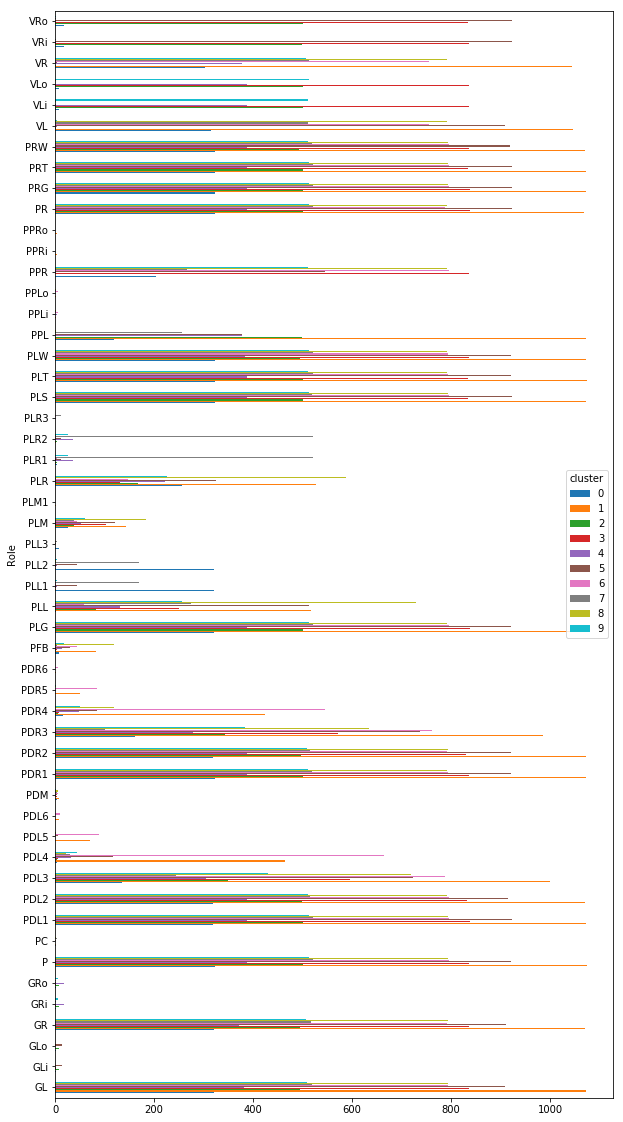

In [13]:
play_roles.groupby('cluster').sum().T.plot(kind='barh', figsize=(10, 20))

# Plot different Clusters

In [14]:
bsnap = pd.read_csv('../working/ballsnap_pos.csv', index_col=0)
bsnap['play_unique'] = bsnap['season_year'].astype('int').astype('str').add((bsnap['gamekey']).astype('int').astype('str')).add((bsnap['playid']).astype('int').astype('str'))

bsnap = pd.merge(bsnap, pprd, left_on=['play_unique','gsisid'], right_on=['play_unique','GSISID']) \
    .drop(columns=['season_year','gamekey','playid','Season_Year','GameKey','PlayID'])
bsnap_pls = bsnap.loc[bsnap['Role'] == 'PLS']
bsnap = pd.merge(bsnap, bsnap_pls[['play_unique','x','y']], on='play_unique', how='left', suffixes=('','_longsnapper'))
bsnap_pr = bsnap.loc[bsnap['Role'] == 'PR']
bsnap = pd.merge(bsnap, bsnap_pr[['play_unique','x','y']], on='play_unique', how='left', suffixes=('','_punt_returner'))

bsnap = pd.merge(bsnap, play_roles[['play_unique','cluster']])

bsnap['left_to_right'] = bsnap.apply(lambda row: True if row['x_longsnapper'] < row['x_punt_returner'] else False, axis=1)

bsnap.loc[bsnap['left_to_right'], 'x_relative'] = bsnap['x'] - bsnap['x_longsnapper']
bsnap.loc[~bsnap['left_to_right'], 'x_relative'] = bsnap['x_longsnapper'] - bsnap['x']
bsnap.loc[bsnap['left_to_right'], 'y_relative'] = bsnap['y'] - bsnap['y_longsnapper']
bsnap.loc[~bsnap['left_to_right'], 'y_relative'] = bsnap['y_longsnapper'] - bsnap['y']

bsnap['x_relative_norm'] = bsnap['x_relative'] + (120 / 2)
bsnap['y_relative_norm'] = bsnap['y_relative'] + (53.3 / 2)

bsnap['Role_nonumbers'] = bsnap['Role'].str.replace('\d+', '')

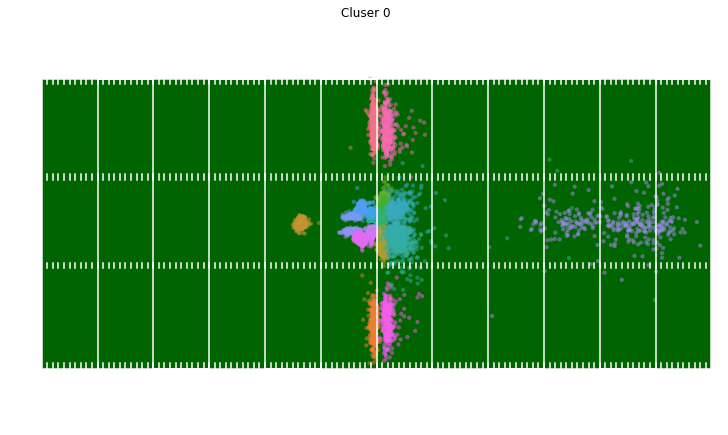

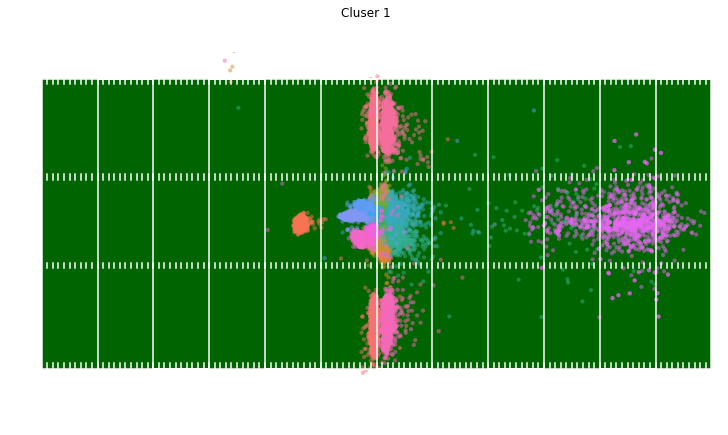

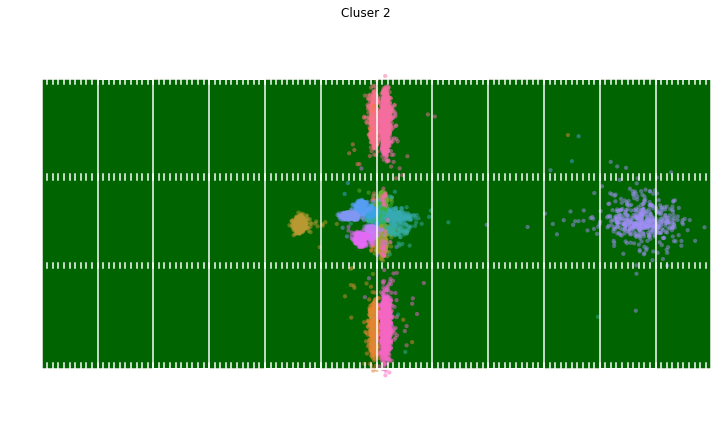

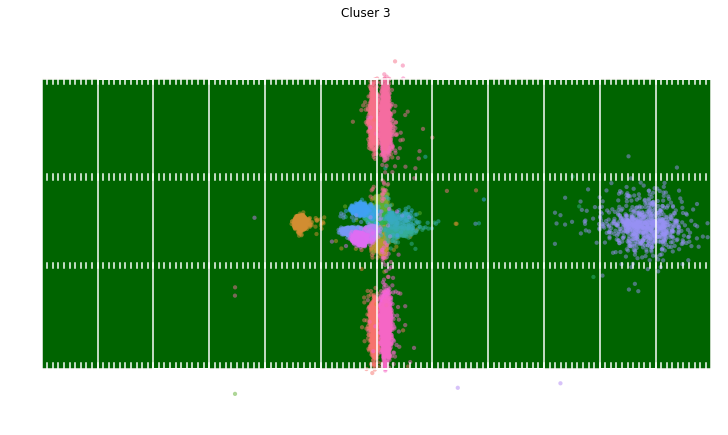

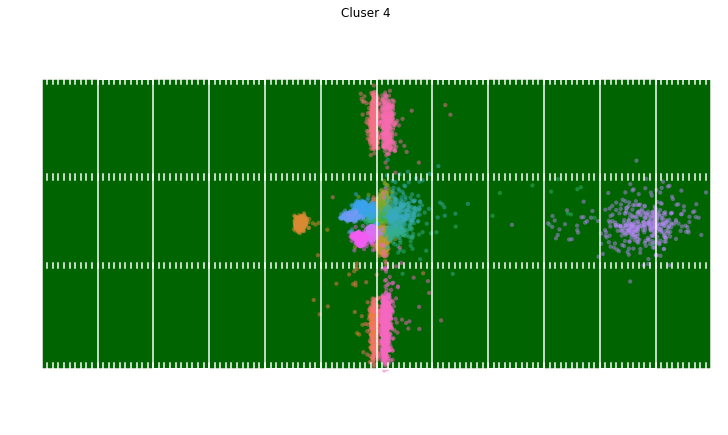

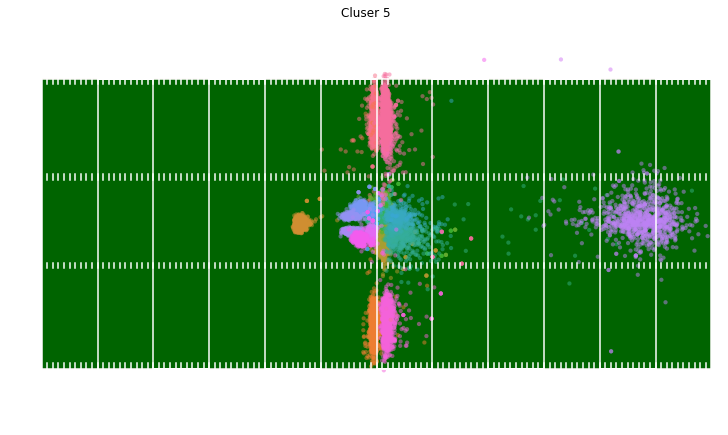

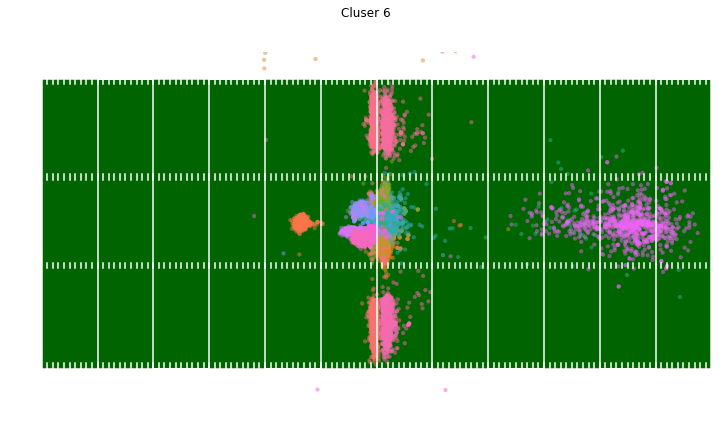

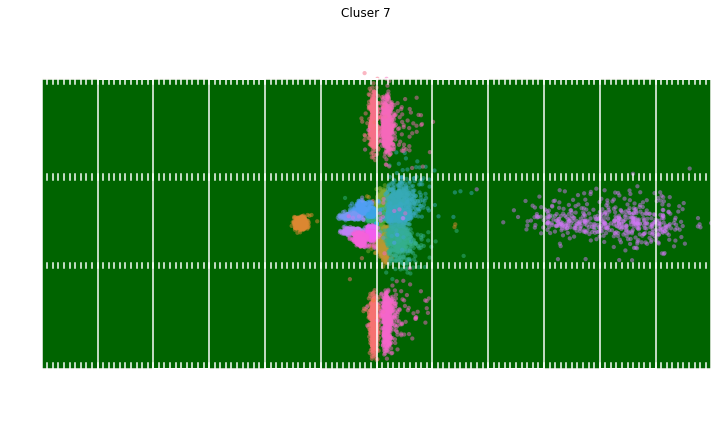

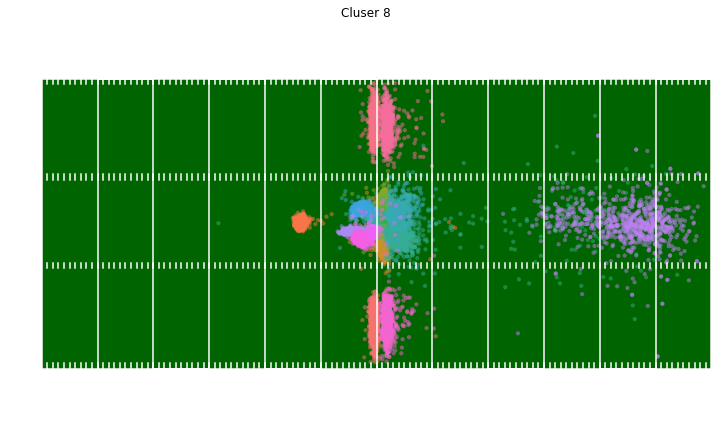

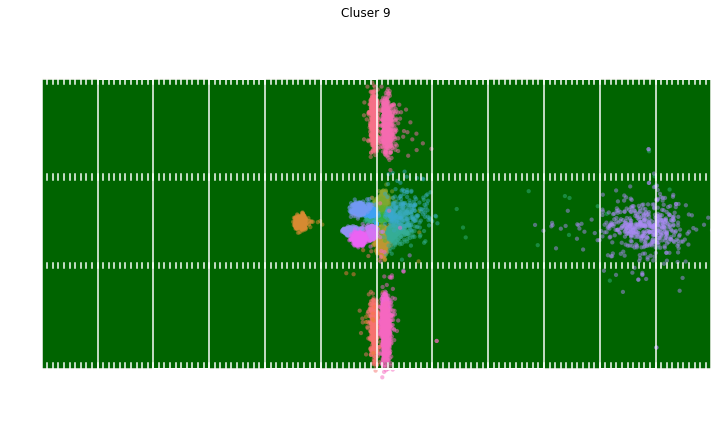

In [15]:
for i, d in bsnap.groupby('cluster'):
    d = d.sort_values('Role')
    fig, ax = create_football_field(linenumbers=False, endzones=False)
    sns.scatterplot(x='x_relative_norm', y='y_relative_norm', hue='Role', data=d, size=15, ax=ax, palette='husl', linewidth=0, alpha=0.5)
    plt.suptitle('Cluser {}'.format(i))
    #print(d.groupby('Role').count()[['x']].sort_values('x'))
    ax.legend_.remove()
    plt.show()

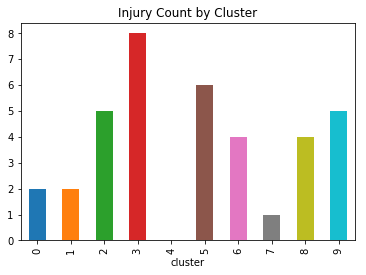

In [16]:
vr['injury_play'] = True
play_roles = pd.merge(play_roles, vr, how='left')
play_roles.groupby('cluster')['injury_play'].sum().plot(kind='bar', title='Injury Count by Cluster')

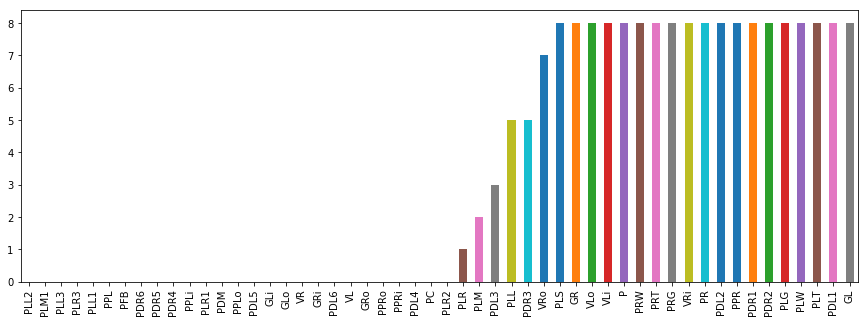

In [17]:
play_roles.loc[(play_roles['cluster'] == 3) &
               (play_roles['injury_play'])].sum()[['GL', 'GLi', 'GLo', 'GR', 'GRi', 'GRo', 'P', 'PC',
                                                  'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDL5', 'PDL6', 'PDM',
                                                  'PDR1', 'PDR2', 'PDR3', 'PDR4',
                                                  'PDR5', 'PDR6', 'PFB', 'PLG', 'PLL', 'PLL1', 'PLL2', 'PLL3',
                                                  'PLM', 'PLM1', 'PLR', 'PLR1',
                                                  'PLR2', 'PLR3', 'PLS', 'PLT', 'PLW', 'PPL', 'PPLi', 'PPLo',
                                                  'PPR', 'PPRi', 'PPRo', 'PR',
                                                  'PRG', 'PRT', 'PRW', 'VL', 'VLi', 'VLo', 'VR', 'VRi', 'VRo']].sort_values().plot(kind='bar', figsize=(15, 5))


# Plot Defensive Formations

In [29]:
# Returning Team
pprd_detailed = pd.merge(pprd, role_info, left_on='Role', right_on='role')
pprd_returning = pprd_detailed.loc[pprd_detailed['punting_returning_team'] == 'Returning_Team']
play_roles_returning = pprd_returning.pivot_table(values='count', index='play_unique', columns='Role', aggfunc='mean').fillna(0).reset_index()

In [30]:
km = KMeans(n_clusters=6, random_state=5)
km.fit(play_roles_returning.set_index('play_unique'))
clusters = km.predict(play_roles_returning.set_index('play_unique'))
play_roles_returning['cluster'] = clusters

In [31]:
bsnap = pd.read_csv('../working/ballsnap_pos.csv', index_col=0)
bsnap['play_unique'] = bsnap['season_year'].astype('int').astype('str').add((bsnap['gamekey']).astype('int').astype('str')).add((bsnap['playid']).astype('int').astype('str'))

bsnap = pd.merge(bsnap, pprd, left_on=['play_unique','gsisid'], right_on=['play_unique','GSISID']) \
    .drop(columns=['season_year','gamekey','playid','Season_Year','GameKey','PlayID'])
bsnap_pls = bsnap.loc[bsnap['Role'] == 'PLS']
bsnap = pd.merge(bsnap, bsnap_pls[['play_unique','x','y']], on='play_unique', how='left', suffixes=('','_longsnapper'))
bsnap_pr = bsnap.loc[bsnap['Role'] == 'PR']
bsnap = pd.merge(bsnap, bsnap_pr[['play_unique','x','y']], on='play_unique', how='left', suffixes=('','_punt_returner'))

bsnap = pd.merge(bsnap, play_roles_returning[['play_unique','cluster']])

bsnap['left_to_right'] = bsnap.apply(lambda row: True if row['x_longsnapper'] < row['x_punt_returner'] else False, axis=1)

bsnap.loc[bsnap['left_to_right'], 'x_relative'] = bsnap['x'] - bsnap['x_longsnapper']
bsnap.loc[~bsnap['left_to_right'], 'x_relative'] = bsnap['x_longsnapper'] - bsnap['x']
bsnap.loc[bsnap['left_to_right'], 'y_relative'] = bsnap['y'] - bsnap['y_longsnapper']
bsnap.loc[~bsnap['left_to_right'], 'y_relative'] = bsnap['y_longsnapper'] - bsnap['y']

bsnap['x_relative_norm'] = bsnap['x_relative'] + (120 / 2)
bsnap['y_relative_norm'] = bsnap['y_relative'] + (53.3 / 2)

bsnap['Role_nonumbers'] = bsnap['Role'].str.replace('\d+', '')

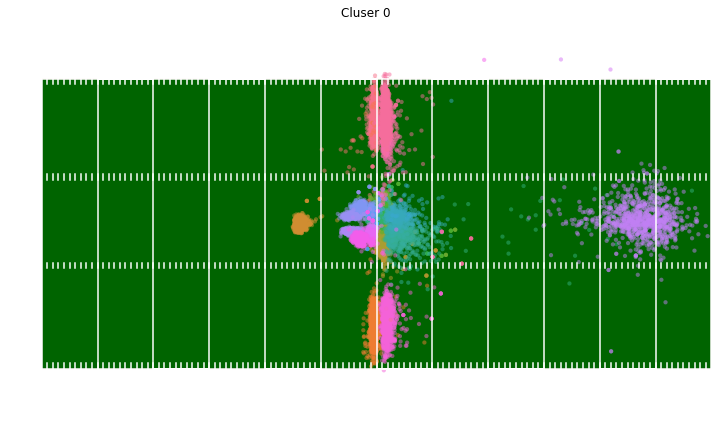

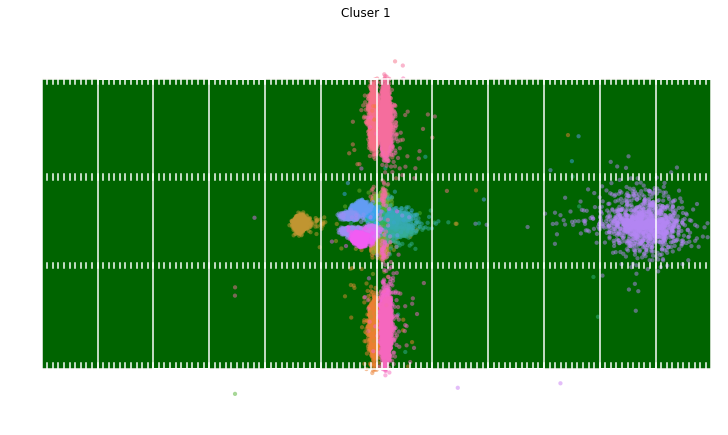

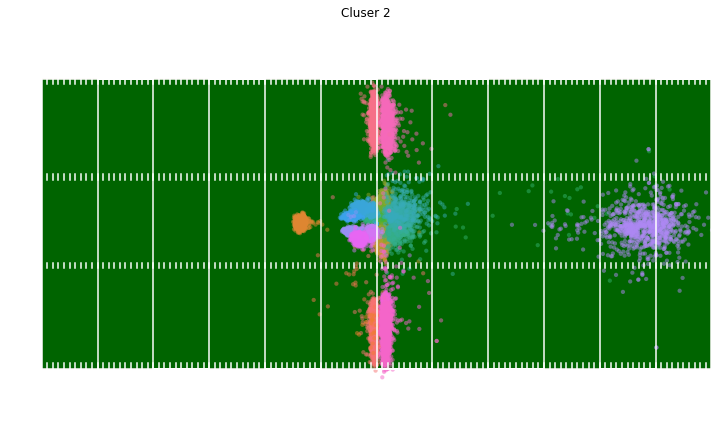

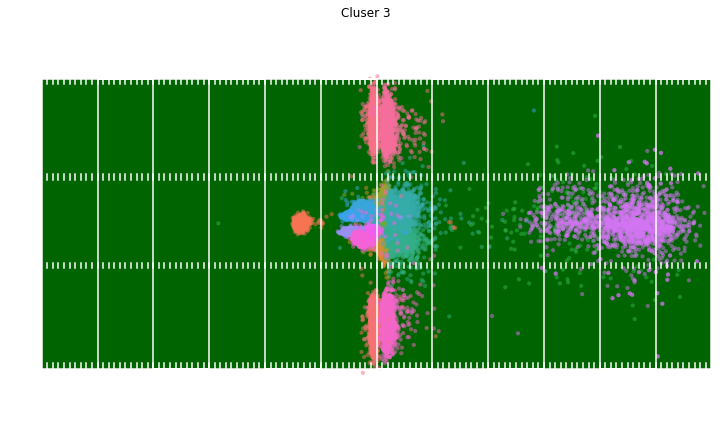

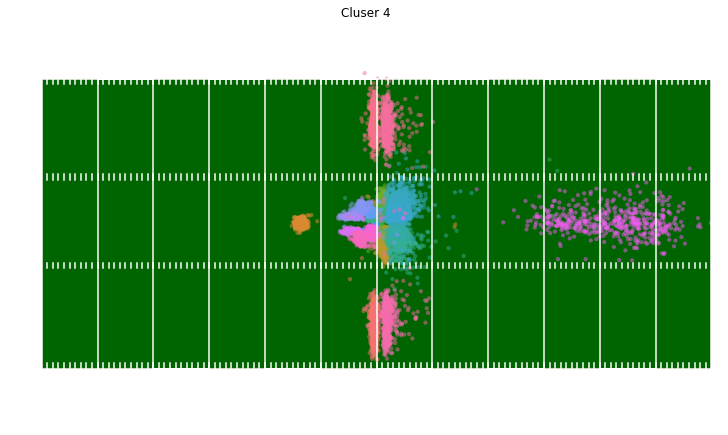

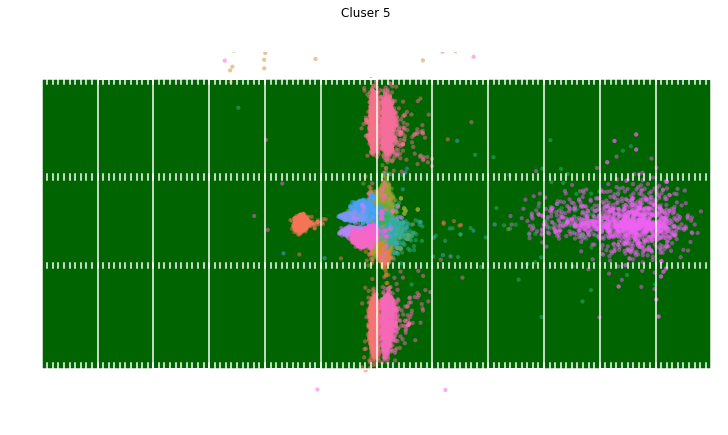

In [32]:
for i, d in bsnap.groupby('cluster'):
    d = d.sort_values('Role')
    fig, ax = create_football_field(linenumbers=False, endzones=False)
    sns.scatterplot(x='x_relative_norm', y='y_relative_norm', hue='Role', data=d, size=15, ax=ax, palette='husl', linewidth=0, alpha=0.5)
    plt.suptitle('Cluser {}'.format(i))
    #print(d.groupby('Role').count()[['x']].sort_values('x'))
    ax.legend_.remove()
    plt.show()

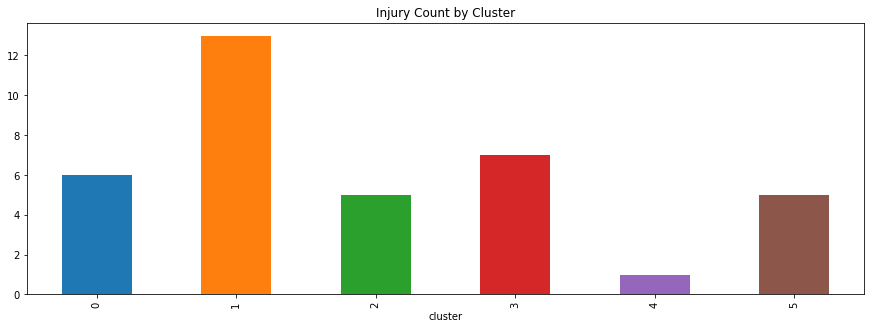

In [33]:
vr_merged['injury_play'] = True
play_roles_returning = pd.merge(play_roles_returning, vr_merged, how='left', on=['play_unique'])
play_roles_returning.groupby('cluster')['injury_play'].sum().plot(kind='bar', title='Injury Count by Cluster', figsize=(15, 5))

/Users/robmulla/anaconda2/envs/kaggle/lib/python3.6/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


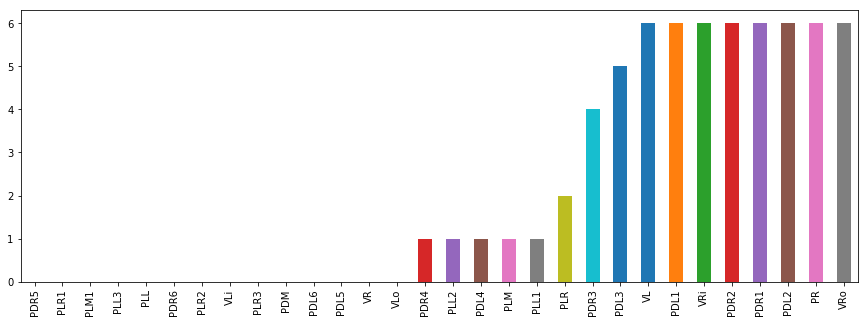

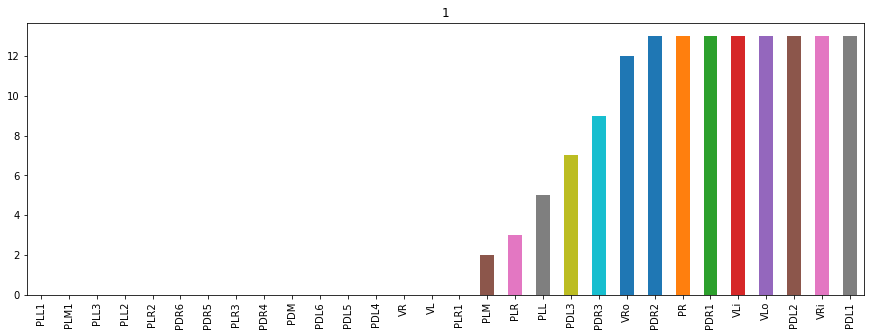

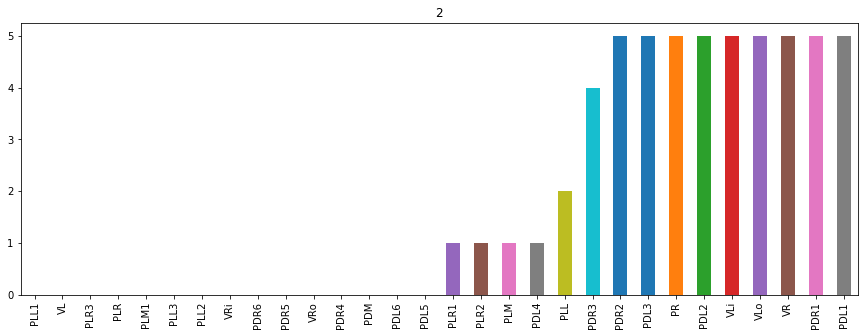

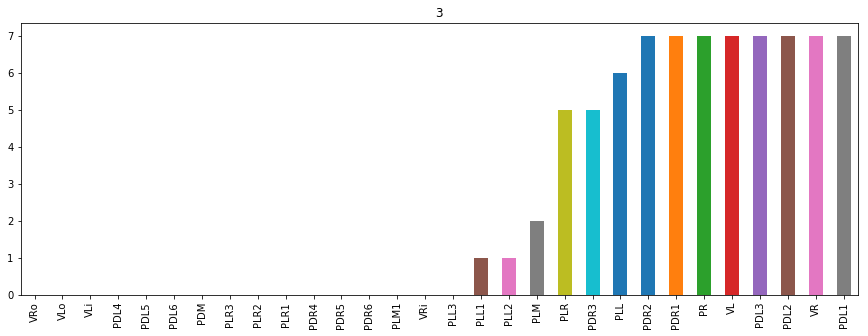

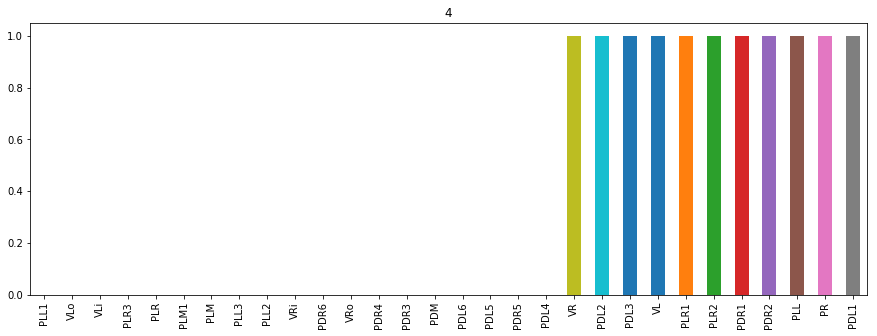

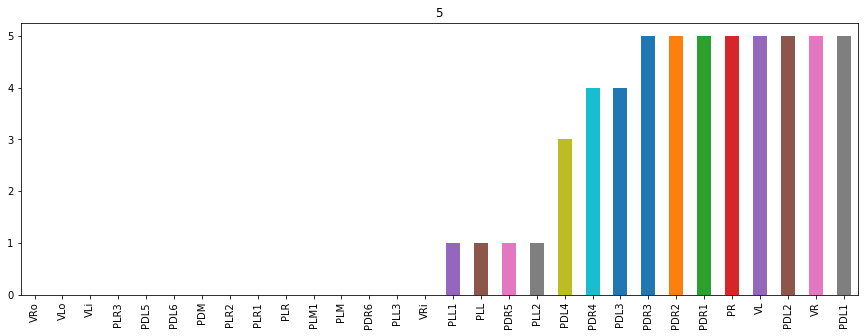

In [34]:
for i, d in play_roles_returning.groupby('cluster'):
    d_inj = d.loc[d['injury_play'].fillna(False)].sum()[['GL', 'GLi', 'GLo', 'GR', 'GRi', 'GRo', 'P', 'PC',
                                                  'PDL1', 'PDL2', 'PDL3', 'PDL4', 'PDL5', 'PDL6', 'PDM',
                                                  'PDR1', 'PDR2', 'PDR3', 'PDR4',
                                                  'PDR5', 'PDR6', 'PFB', 'PLG', 'PLL', 'PLL1', 'PLL2', 'PLL3',
                                                  'PLM', 'PLM1', 'PLR', 'PLR1',
                                                  'PLR2', 'PLR3', 'PLS', 'PLT', 'PLW', 'PPL', 'PPLi', 'PPLo',
                                                  'PPR', 'PPRi', 'PPRo', 'PR',
                                                  'PRG', 'PRT', 'PRW', 'VL', 'VLi', 'VLo', 'VR', 'VRi', 'VRo']]
    d_inj.dropna().sort_values().plot(kind='bar', figsize=(15, 5), title=i)
    plt.show()

20162183468


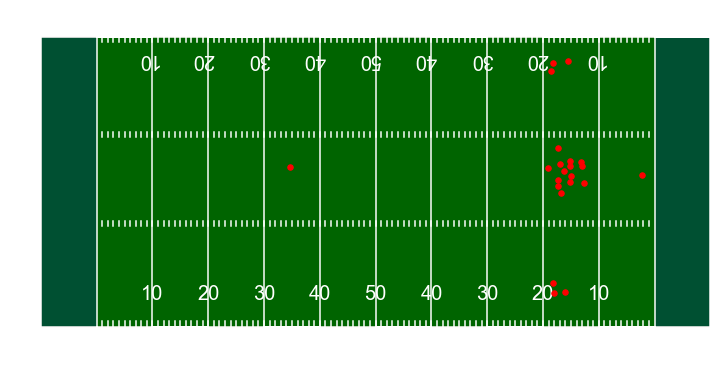

20162311976


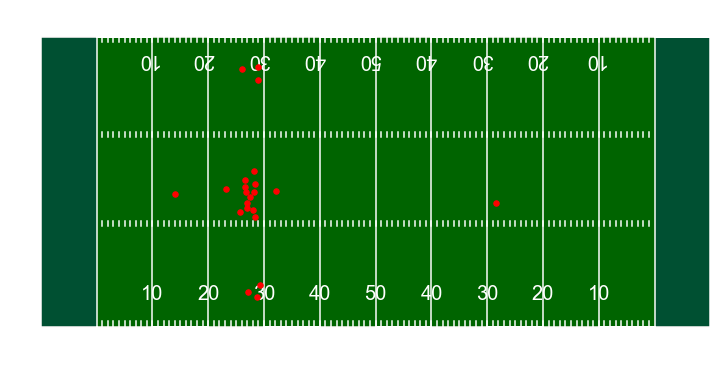

20162743609


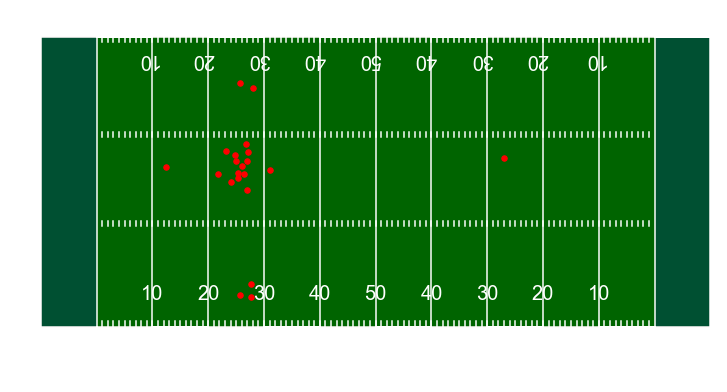

20162811526


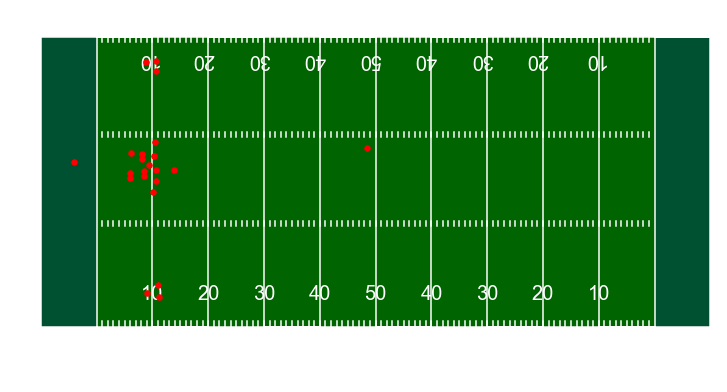

2016541045


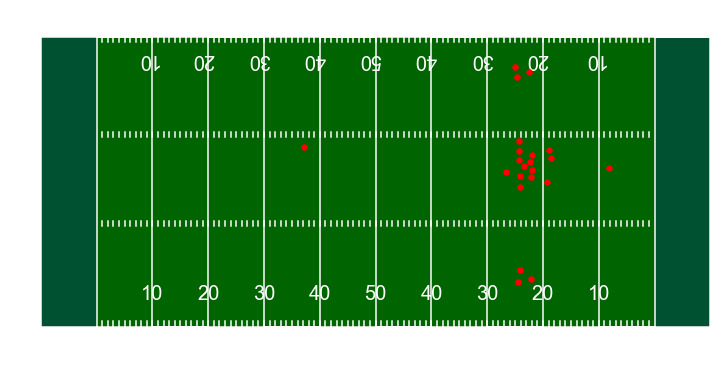

201660905


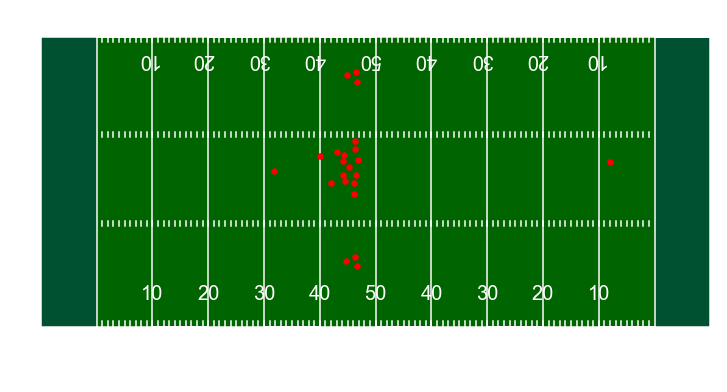

20173573630


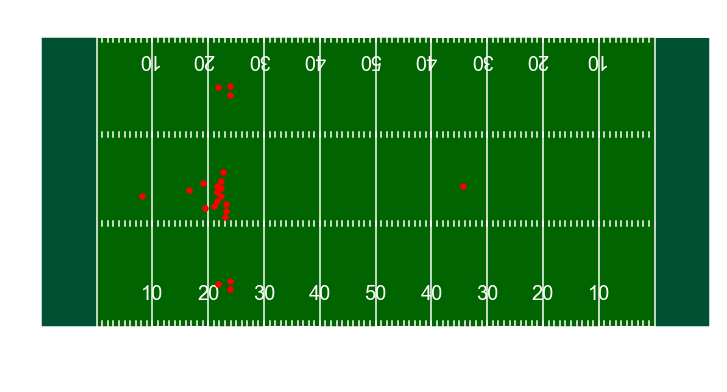

2017384183


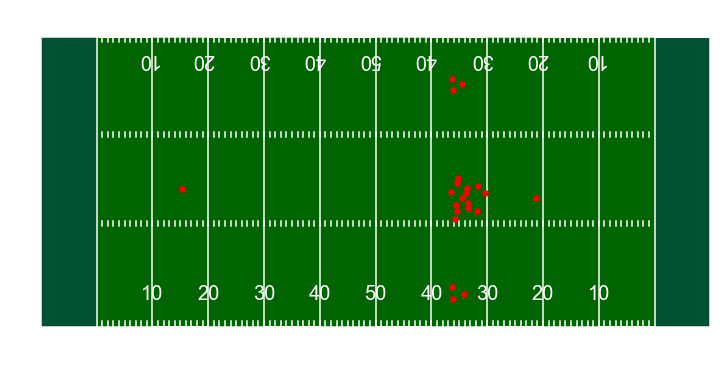

20173921088


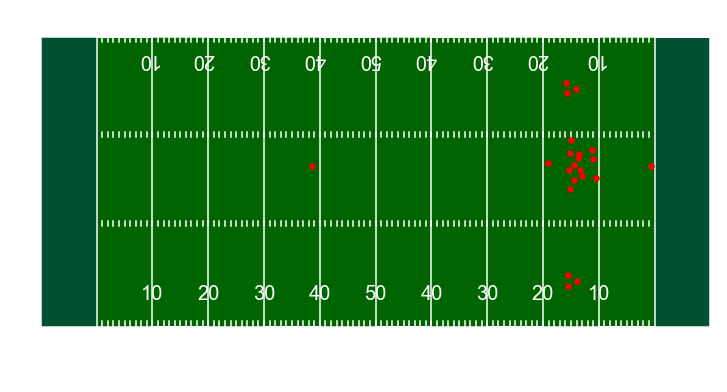

20173971526


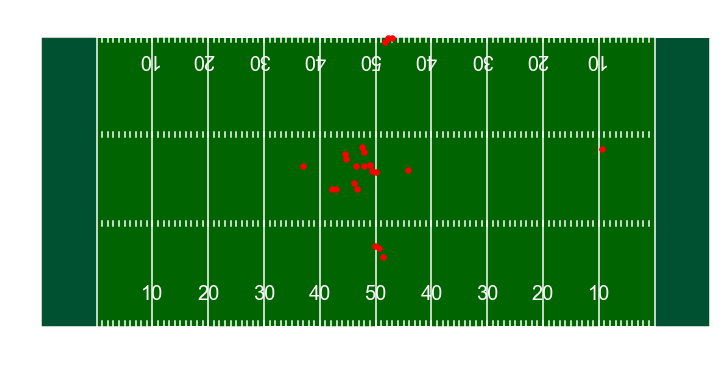

20174141262


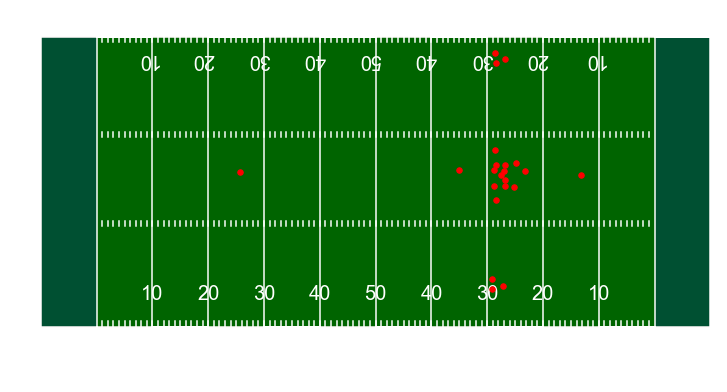

20174482792


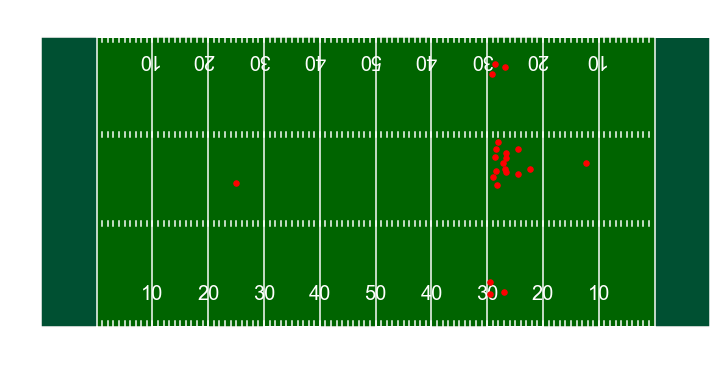

20175531683


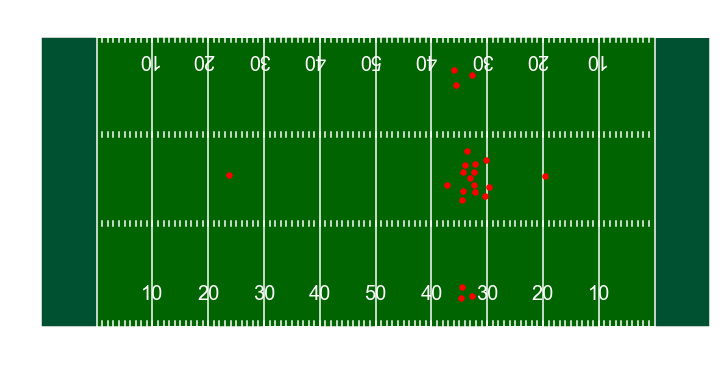

In [42]:
for d in play_roles_returning.loc[(play_roles_returning['cluster'] == 1) & (play_roles_returning['injury_play'])].iterrows():
    play_unique = d[1]['play_unique']
    print(play_unique)
    fig, ax = create_football_field()
    bsnap.loc[bsnap['play_unique'] == play_unique].plot('x', 'y', kind='scatter', ax=ax, zorder=5, s=30, color='red')
    plt.show()

# See Injured Player by cluster

In [37]:
pd.merge(play_roles_returning.dropna().sort_values('cluster'), vr_merged)[['play_unique','cluster','Role_x','Role_y']]

,play_unique,cluster,Role_x,Role_y
0,20176182792,0,PRG,PDR1
1,20161493663,0,PFB,PRT
2,20174732072,0,PRG,PLT
3,20162802918,0,PLW,PDR1
4,20173642764,0,PLG,PDR1
5,201653129,0,PLW,PR
6,20175531683,1,PDL2,PLS
7,20174482792,1,PDR1,PRG
8,20174141262,1,PLW,None
9,20173971526,1,PLT,PR


# Number of Jammers by Play

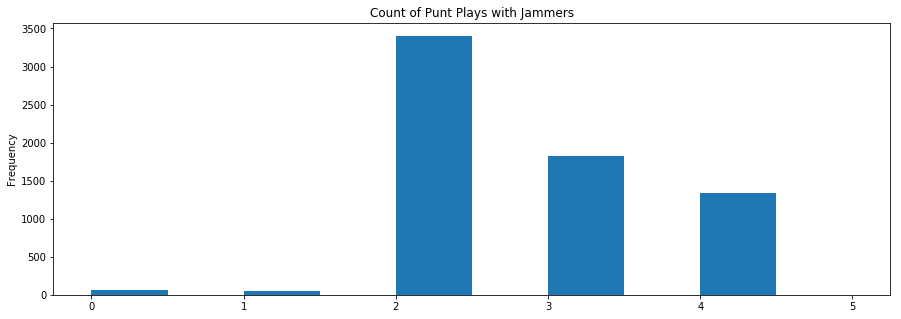

In [20]:
play_roles['Number_of_jammers'] = play_roles[['VL','VLi','VLo','VR','VRi','VRo']].sum(axis=1)
play_roles['Number_of_jammers'].plot(kind='hist', figsize=(15, 5), title='Count of Punt Plays with Jammers')

In [21]:
vr_merged['injury_play'] = True
play_roles = pd.merge(play_roles, vr_merged, on='play_unique', how='left')

In [22]:
play_roles.groupby('Number_of_jammers')['injury_play_x'].sum()

Number_of_jammers
0.0     0
1.0     0
2.0    13
3.0    12
4.0    12
5.0     0
Name: injury_play_x, dtype: int64

In [23]:
play_roles.groupby('Number_of_jammers')['injury_play_x'].sum() / play_roles.groupby('Number_of_jammers')['play_unique'].count()

Number_of_jammers
0.0    0.000000
1.0    0.000000
2.0    0.003821
3.0    0.006579
4.0    0.008996
5.0    0.000000
dtype: float64

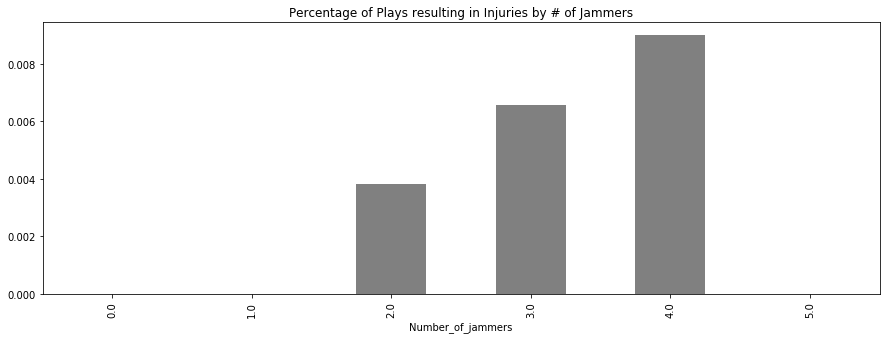

In [26]:
(play_roles.groupby('Number_of_jammers')['injury_play_x'].sum() / play_roles.groupby('Number_of_jammers')['play_unique'] \
     .count()).plot(kind='bar', figsize=(15, 5), color='grey', title='Percentage of Plays resulting in Injuries by # of Jammers')


## Number of Gunners

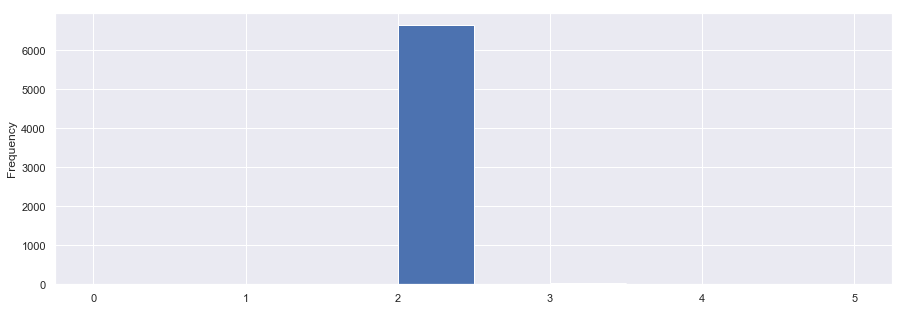

In [298]:
play_roles['Number_of_gunners'] = play_roles[['GL','GLi','GLo','GR','GRi','GRo']].sum(axis=1)
play_roles['Number_of_gunners'].plot(kind='hist', figsize=(15, 5))